In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='admin123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/CCS/Downloads/archive (2)'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [ ]:
pip install --upgrade pip

In [1]:
pip install pandas


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [1]:
pip install mysql-connector-python


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "admin123",
                             database = "ecommerce")

cur = db.cursor()


# List all unique cities where customers are located.


In [71]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()



,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [74]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]


('total orders placed in 2017 are', 180404)

# 3. Find the total sales per category.

In [77]:
query = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df.head()

,Category,Sales
0,PERFUMERY,13681943.82
1,FURNITURE DECORATION,38614762.58
2,TELEPHONY,13145815.37
3,BED TABLE BATH,46238949.12
4,AUTOMOTIVE,23011946.94
...,...,...
69,CDS MUSIC DVDS,32384.61
70,LA CUISINE,78665.31
71,FASHION CHILDREN'S CLOTHING,21213.09
72,PC GAMER,58709.61


# Calculate the percentage of orders that were paid in installments.

In [79]:



query = """ select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments

"""

cur.execute(query)

data = cur.fetchall()
" percentage of orders that were paid in installments is ",data[0][0]

(' percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# Count the number of customers from each state. 

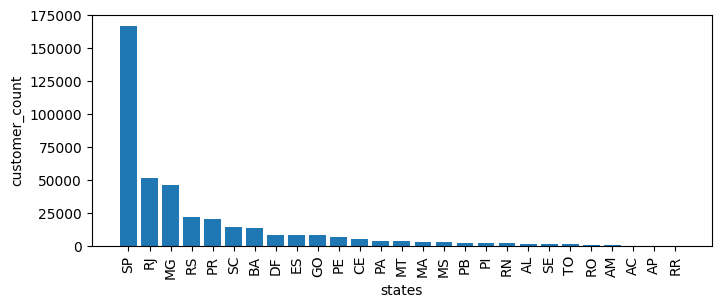

In [81]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by =  "customer_count", ascending = False)
plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation= 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.show()

# Intermediate Queries


# 1. Calculate the number of orders per month in 2018.

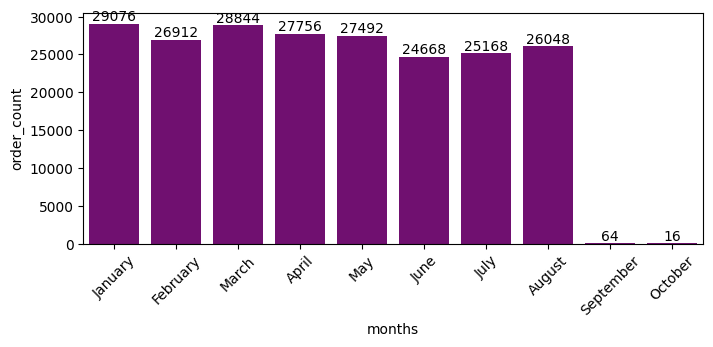

In [89]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id)
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
plt.figure(figsize = (8,3))
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color = "purple")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])

plt.show()
     

# 2. Find the average number of products per order, grouped by customer city.

In [101]:
query = """ WITH count_per_order AS (
    SELECT 
        orders.order_id, 
        orders.customer_id, 
        COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items
        ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city, 
    ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers 
JOIN count_per_order
    ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city;

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["customer city", "average orders"] )
df.head()

,customer city,average orders
0,treze tilias,15.27
1,indaial,13.38
2,sao jose dos campos,13.66
3,sao paulo,13.87
4,porto alegre,14.10


# 3. Calculate the percentage of total revenue contributed by each product category.

In [111]:
query = """SELECT 
    UPPER(products.product_category) AS category,
    ROUND(
        (SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100,
        2
    ) AS sales
FROM products
JOIN order_items
    ON products.product_id = order_items.product_id
JOIN payments
    ON payments.order_id = order_items.order_id
GROUP BY products.product_category
ORDER BY sales DESC;

"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["Category", "percentage distribution"] )
df.head()


,Category,percentage distribution
0,BED TABLE BATH,96.28
1,HEALTH BEAUTY,93.18
2,COMPUTER ACCESSORIES,89.13
3,FURNITURE DECORATION,80.40
4,WATCHES PRESENT,80.35


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [134]:
query = """
SELECT 
    products.product_category,
    COUNT(order_items.product_id) AS product_count,
    ROUND(AVG(order_items.price), 2) AS avg_price
FROM products
JOIN order_items 
    ON products.product_id = order_items.product_id
GROUP BY products.product_category;


"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["Category", "Product Count", "Avg Product Price"])

arr1 = df["Product Count"]
arr2 = df["Avg Product Price"]

np.corrcoef([arr1,arr2])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# 5. Calculate the total revenue generated by each seller, and rank them by revenue.



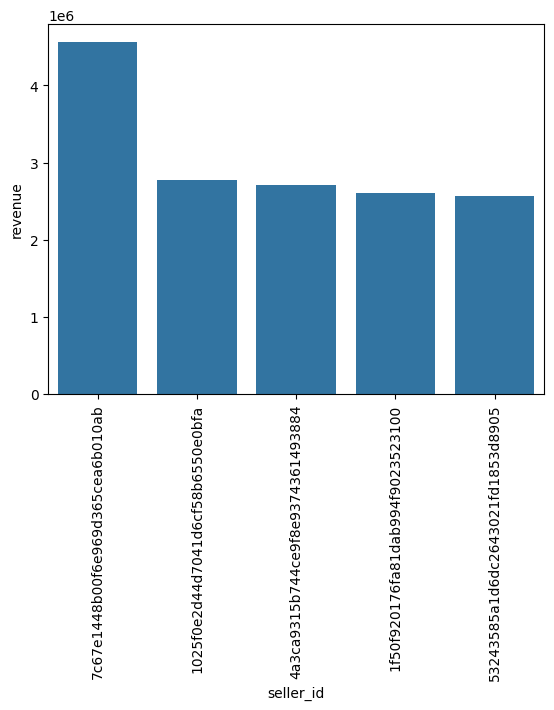

In [159]:
query = """
SELECT 
    *,
    DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn
FROM (
    SELECT 
        order_items.seller_id, 
        SUM(payments.payment_value) AS revenue
    FROM order_items 
    JOIN payments
        ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS t;

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()


# Advanced Queries


# 1. Calculate the moving average of order values for each customer over their order history.

In [165]:
query = """
select customer_id , order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a

"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1246627,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1246628,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1246629,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1246630,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 2. Calculate the cumulative sales per month for each year.


In [170]:
query = """
select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""

cur.execute(query)

data = cur.fetchall()
data


[(2016, 9, 3026.88, 3026.88),
 (2016, 10, 709085.76, 712112.64),
 (2016, 12, 235.44, 712348.08),
 (2017, 1, 1661856.48, 2374204.56),
 (2017, 2, 3502896.11, 5877100.67),
 (2017, 3, 5398363.19, 11275463.86),
 (2017, 4, 5013456.35, 16288920.209999999),
 (2017, 5, 7115025.84, 23403946.049999997),
 (2017, 6, 6135316.56, 29539262.609999996),
 (2017, 7, 7108595.03, 36647857.63999999),
 (2017, 8, 8092755.84, 44740613.47999999),
 (2017, 9, 8733149.4, 53473762.87999999),
 (2017, 10, 9356134.56, 62829897.43999999),
 (2017, 11, 14338593.6, 77168491.03999999),
 (2017, 12, 10540817.76, 87709308.8),
 (2018, 1, 13380050.15, 101089358.95),
 (2018, 2, 11909560.08, 112998919.03),
 (2018, 3, 13915825.44, 126914744.47),
 (2018, 4, 13929425.77, 140844170.24),
 (2018, 5, 13847785.81, 154691956.05),
 (2018, 6, 12286566.01, 166978522.06),
 (2018, 7, 12798488.99, 179777011.05),
 (2018, 8, 12269103.86, 192046114.91000003),
 (2018, 9, 53274.48, 192099389.39000002),
 (2018, 10, 7076.04, 192106465.43)]

# 3. Calculate the year-over-year growth rate of total sales.

In [179]:
query = """
with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a 
"""


cur.execute(query)

data = cur.fetchall()
df =  pd.DataFrame(data, columns = ["years", "yoy % growth"])
df
                                 


,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [184]:
query = """with a as (
  select o.customer_id, min(o.order_purchase_timestamp) as first_order
  from orders o
  group by o.customer_id
),
b as (
  select a.customer_id,
         count(distinct o.order_id) as next_order
  from a
  join orders o
    on o.customer_id = a.customer_id
   and o.order_purchase_timestamp > a.first_order
   and o.order_purchase_timestamp < date_add(a.first_order, interval 6 month)
  group by a.customer_id
)
select 100.0 * count(distinct b.customer_id) / count(distinct a.customer_id) as pct_returned_6m
from a
left join b on a.customer_id = b.customer_id;

"""
cur.execute(query)

data = cur.fetchall()
df =  pd.DataFrame(data)
df
                                 


,0
0,0.00000


# 5. Identify the top 3 customers who spent the most money in each year.

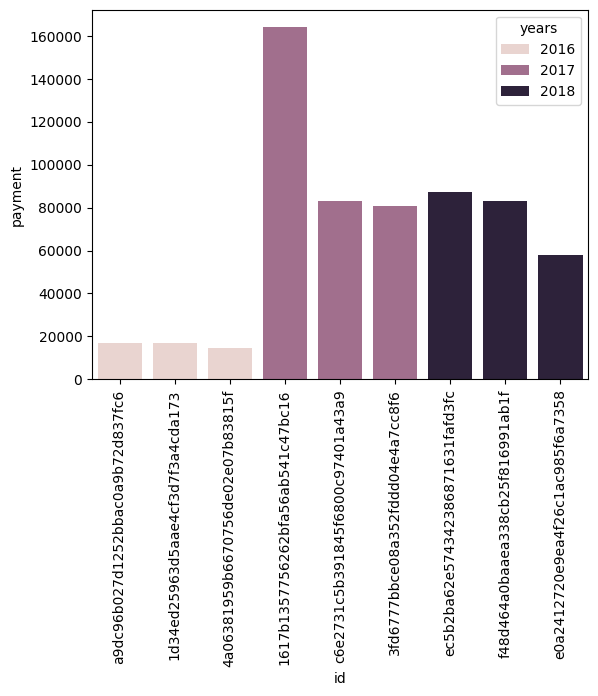

In [187]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()